In [2]:
from __future__ import print_function, division

import keras
# Using 
# from keras.datasets import mnist
# from keras.models import Model, load_model

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Input, Lambda
from keras.optimizers import RMSprop
from keras.utils import to_categorical
# from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from pathlib import Path
import imageio
import numpy as np
%matplotlib inline
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from scipy import ndimage
from matplotlib.colors import ListedColormap
from skimage.feature import peak_local_max
from skimage import measure
import os
from keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize
import random
import os
import sys
import random
import warnings
from tqdm import tqdm
import tensorflow as tf

import pandas as pd

from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.layers.core import  Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.preprocessing import image

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'



/home/emma/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
train_ids = next(os.walk(TRAIN_PATH))[1]

In [4]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [01:58<00:00,  5.64it/s]


In [5]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# CNN

In [6]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = Conv2D(16, (2, 2),strides =2, activation='relu', kernel_initializer='he_normal', padding='valid') (c1) #128x128x16

c2 = Conv2D(16, (6, 6), activation='relu',  kernel_initializer='he_normal', padding = 'same') (c1) #62x62x16
c2 = Dropout(0.1) (c2)

u1 = Conv2DTranspose(16, (65, 65), padding='valid') (c2)
c3 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u1)

u2 = Conv2DTranspose(16, (65, 65), padding='valid') (c3)
c4 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u2)

outputs = Conv2D(1, (1, 1), activation='tanh') (c4)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 16)      1040      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 16)      9232      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 192, 192, 16)      1081616   
__________

In [ ]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('changingthestride.h5', verbose=1, save_best_only=True)
# history = LossHistory()
results2 = model.fit(X_train, Y_train,validation_split=0.1, batch_size=16,epochs=10, 
                              callbacks=[ earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/10


In [6]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# Augment Images to create a larger sample

In [7]:
seed =142
data_gen_args = dict(rotation_range=90.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range = 0.2,
                     horizontal_flip = True,
                     vertical_flip = True, 
                     fill_mode = 'constant',
                     zoom_range=0.2)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

image_datagen.fit(X_train[:int(X_train.shape[0]*0.9)], augment=True, seed=seed)
mask_datagen.fit(Y_train[:int(Y_train.shape[0]*0.9)], augment=True, seed=seed)

x=image_datagen.flow(X_train[:int(X_train.shape[0]*0.9)],
                     batch_size=32,
                     shuffle=True, 
                     seed=seed)
y=mask_datagen.flow(Y_train[:int(Y_train.shape[0]*0.9)],
                    batch_size=32,
                    shuffle=True, 
                    seed=seed)



# Creating the validation Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(X_train[int(X_train.shape[0]*0.9):], augment=True, seed=seed)
mask_datagen_val.fit(Y_train[int(Y_train.shape[0]*0.9):], augment=True, seed=seed)

x_val=image_datagen_val.flow(X_train[int(X_train.shape[0]*0.9):],
                             batch_size=32,
                             shuffle=True, 
                             seed=seed)
y_val=mask_datagen_val.flow(Y_train[int(Y_train.shape[0]*0.9):],
                            batch_size=32,
                            shuffle=True, 
                            seed=seed)

train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
history = LossHistory()
results = model.fit_generator(train_generator, 
                              validation_data=val_generator, 
                              validation_steps=32/2, 
                              steps_per_epoch=int(len(X_train)/(32*2)),
                              epochs=10, 
                              callbacks=[ earlystopper, checkpointer])



Epoch 1/10
1/1 [==============================] - 42s 42s/step - loss: 1.3211 - mean_iou: 0.0000e+00 - val_loss: 0.3948 - val_mean_iou: 0.0203

Epoch 00001: val_loss improved from inf to 0.39476, saving model to model-dsbowl2018-1.h5
Epoch 2/10
1/1 [==============================] - 39s 39s/step - loss: 0.6204 - mean_iou: 0.0092 - val_loss: 0.3514 - val_mean_iou: 0.0255

Epoch 00002: val_loss improved from 0.39476 to 0.35139, saving model to model-dsbowl2018-1.h5
Epoch 3/10
1/1 [==============================] - 37s 37s/step - loss: 0.3789 - mean_iou: 0.0328 - val_loss: 0.3800 - val_mean_iou: 0.0492

Epoch 00003: val_loss did not improve
Epoch 4/10
1/1 [==============================] - 39s 39s/step - loss: 0.4191 - mean_iou: 0.0611 - val_loss: 0.3981 - val_mean_iou: 0.0737

Epoch 00004: val_loss did not improve
Epoch 5/10
1/1 [==============================] - 38s 38s/step - loss: 0.5244 - mean_iou: 0.0823 - val_loss: 0.3959 - val_mean_iou: 0.0900

Epoch 00005: val_loss did not improv

# Plots image segmentation

In [9]:
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)

10/10 [==============================] - 1s 133ms/step


Text(0.5,1,'predicition')

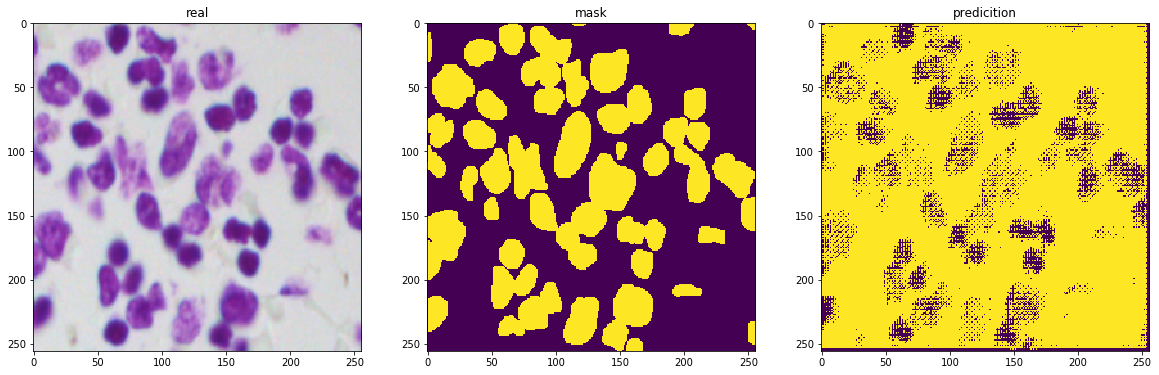

In [10]:
plt.figure(figsize = (20,20))
ix = random.randint(0, len(preds_train))

plt.subplot(1,3,1)
plt.imshow(X_train[ix])
plt.title('real')

plt.subplot(1,3,2)
plt.imshow(np.squeeze(Y_train[ix]))
plt.title('mask')

plt.subplot(1,3,3)
plt.imshow(np.squeeze(preds_train[ix]>0.5))
plt.title('predicition')

Text(0.5,1,'predicition')

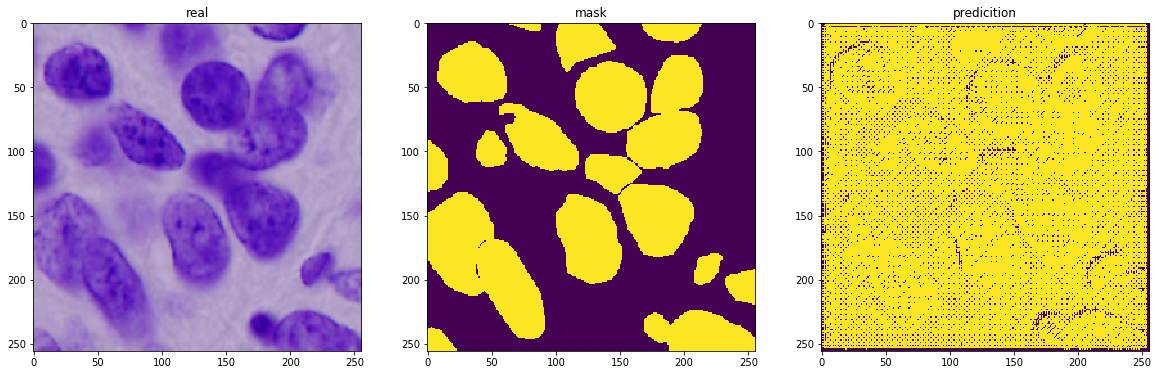

In [11]:
plt.figure(figsize = (20,20))
ix = random.randint(0, len(preds_val))
# ix = 0
plt.subplot(1,3,1)
plt.imshow(X_train[90 + ix])
plt.title('real')

plt.subplot(1,3,2)
plt.imshow(np.squeeze(Y_train[90 +ix]))
plt.title('mask')

plt.subplot(1,3,3)
plt.imshow(np.squeeze(preds_val[ix]>0.5))
plt.title('predicition')

# Do it on the real data

In [1]:
TRAINING_PATH = 'stage1_train/'
TESTING_PATH = 'stage1_test/'

In [5]:
training_ids = next(os.walk(TRAINING_PATH))[1]
testing_ids = next(os.walk(TESTING_PATH))[1]

In [6]:
X_training = np.zeros((len(training_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_training = np.zeros((len(training_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(training_ids), total=len(training_ids)):
    path = TRAINING_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_training[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_training[n] = mask

# Get and resize test images
X_test = np.zeros((len(testing_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(testing_ids), total=len(testing_ids)):
    path = TESTING_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [02:06<00:00,  5.28it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:00<00:00, 66.64it/s]


# UNET Model

In [8]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='tanh') (c9)

model2 = Model(inputs=[inputs], outputs=[outputs])
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

# Unet with Image Augmentation 

In [25]:
from keras.preprocessing import image
seed =142
data_gen_args = dict(rotation_range=90.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range = 0.2,
                     horizontal_flip = True,
                     vertical_flip = True, 
                     fill_mode = 'constant',
                     zoom_range=0.2)
image_datagen2 = ImageDataGenerator(**data_gen_args)
mask_datagen2 = ImageDataGenerator(**data_gen_args)

image_datagen2.fit(X_training[:int(X_training.shape[0]*0.9)], augment=True, seed=seed)
mask_datagen2.fit(Y_training[:int(Y_training.shape[0]*0.9)], augment=True, seed=seed)

x2=image_datagen2.flow(X_training[:int(X_training.shape[0]*0.9)],
                     batch_size=16,
                     shuffle=True, 
                     seed=seed)
y2=mask_datagen2.flow(Y_training[:int(Y_training.shape[0]*0.9)],
                    batch_size=16,
                    shuffle=True, 
                    seed=seed)



# Creating the validation Image and Mask generator
image_datagen_val2 = image.ImageDataGenerator()
mask_datagen_val2 = image.ImageDataGenerator()

image_datagen_val2.fit(X_training[int(X_training.shape[0]*0.9):], augment=True, seed=seed)
mask_datagen_val2.fit(Y_training[int(Y_training.shape[0]*0.9):], augment=True, seed=seed)

x_val2=image_datagen_val2.flow(X_training[int(X_training.shape[0]*0.9):],
                             batch_size=16,
                             shuffle=True, 
                             seed=seed)
y_val2=mask_datagen_val2.flow(Y_training[int(Y_training.shape[0]*0.9):],
                            batch_size=16,
                            shuffle=True, 
                            seed=seed)

train_generator2 = zip(x2, y2)
val_generator2 = zip(x_val2, y_val2)

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-UNET1.h5', verbose=1, save_best_only=True)
history = LossHistory()
results2 = model2.fit_generator(train_generator2, 
                              validation_data=val_generator2, 
                              validation_steps=int(67/16), 
                              steps_per_epoch=200,
                              epochs=50, 
                              callbacks=[ earlystopper, checkpointer])



Epoch 1/50
200/200 [==============================] - 1508s 8s/step - loss: 0.2415 - mean_iou: 0.1233 - val_loss: 0.1290 - val_mean_iou: 0.2181

Epoch 00001: val_loss improved from inf to 0.12902, saving model to model-dsbowl2018-UNET1.h5
Epoch 2/50
200/200 [==============================] - 1412s 7s/step - loss: 0.0926 - mean_iou: 0.2914 - val_loss: 0.1136 - val_mean_iou: 0.3405

Epoch 00002: val_loss improved from 0.12902 to 0.11356, saving model to model-dsbowl2018-UNET1.h5
Epoch 3/50
200/200 [==============================] - 1410s 7s/step - loss: 0.0808 - mean_iou: 0.3680 - val_loss: 0.1076 - val_mean_iou: 0.3918

Epoch 00003: val_loss improved from 0.11356 to 0.10763, saving model to model-dsbowl2018-UNET1.h5
Epoch 4/50
200/200 [==============================] - 1402s 7s/step - loss: 0.0726 - mean_iou: 0.4091 - val_loss: 0.0833 - val_mean_iou: 0.4241

Epoch 00004: val_loss improved from 0.10763 to 0.08330, saving model to model-dsbowl2018-UNET1.h5
Epoch 5/50
200/200 [============

In [12]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-UNET1_withoutaug.h5', verbose=1, save_best_only=True)
# history = LossHistory()
results2 = model2.fit(X_training, Y_training,validation_split=0.1, batch_size=16,epochs=50, 
                              callbacks=[ earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/50
603/603 [==============================] - 276s 458ms/step - loss: 0.4413 - mean_iou: 0.0170 - val_loss: 0.4377 - val_mean_iou: 0.0151

Epoch 00001: val_loss improved from inf to 0.43772, saving model to model-dsbowl2018-UNET1_withoutaug.h5
Epoch 2/50
603/603 [==============================] - 273s 453ms/step - loss: 0.3885 - mean_iou: 0.0134 - val_loss: 0.3697 - val_mean_iou: 0.0121

Epoch 00002: val_loss improved from 0.43772 to 0.36969, saving model to model-dsbowl2018-UNET1_withoutaug.h5
Epoch 3/50
603/603 [==============================] - 269s 447ms/step - loss: 0.3010 - mean_iou: 0.0114 - val_loss: 0.3165 - val_mean_iou: 0.0141

Epoch 00003: val_loss improved from 0.36969 to 0.31649, saving model to model-dsbowl2018-UNET1_withoutaug.h5
Epoch 4/50
603/603 [==============================] - 270s 448ms/step - loss: 0.2113 - mean_iou: 0.0227 - val_loss: 0.1874 - val_mean_iou: 0.0333

Epoch 00004: val_loss improved from 0.31649 

# Epoch Learning Curve

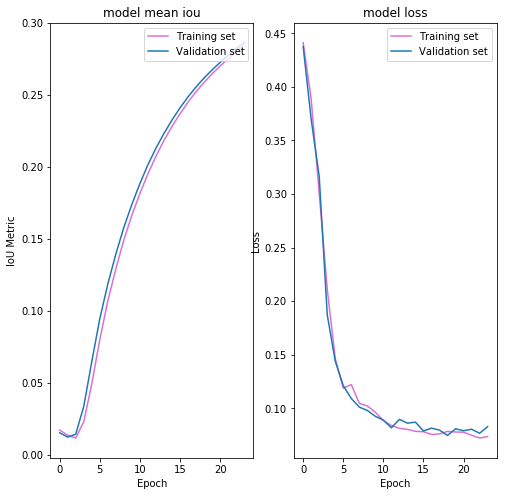

OSError: Failed to interpret file 'model-dsbowl2018-mlp_subimage_testing2.h5' as a pickle

In [13]:
def plotKerasLearningCurve(filename):
    plt.figure(figsize=(10,5))
    metrics = np.load(filename)[()]
    filt = ['mean_iou'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['mean_iou'], color = 'orchid')
    plt.plot(history.history['val_mean_iou'])
    plt.title('model mean iou')
    plt.ylabel('IoU Metric')
    plt.xlabel('Epoch')
    plt.legend(['Training set', 'Validation set'], loc='upper right')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], color = 'orchid')
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training set', 'Validation set'], loc='upper right')
    plt.savefig('./loss_curve.png')
plot_learning_curve(results2)
plt.show()
plotKerasLearningCurve('model-dsbowl2018-mlp_subimage_testing2.h5')
plt.show()

In [15]:
model3 = load_model('model-dsbowl2018-UNET1_withoutaug.h5', custom_objects={'mean_iou': mean_iou})

preds_training = model3.predict(X_training[:int(X_training.shape[0]*0.9)], verbose=1)
# preds_training = preds_training.reshape(603, 256, 256, 1)

preds_valid = model3.predict(X_training[int(X_training.shape[0]*0.9):], verbose=1)
# preds_valid = preds_valid.reshape(67, 256, 256, 1)

preds_test = model3.predict(X_test, verbose=1)

# preds_test = preds_test.reshape(len(X_test), 256, 256, 1)

65/65 [==============================] - 9s 133ms/step


Text(0.5,1,'Predicted Mask')

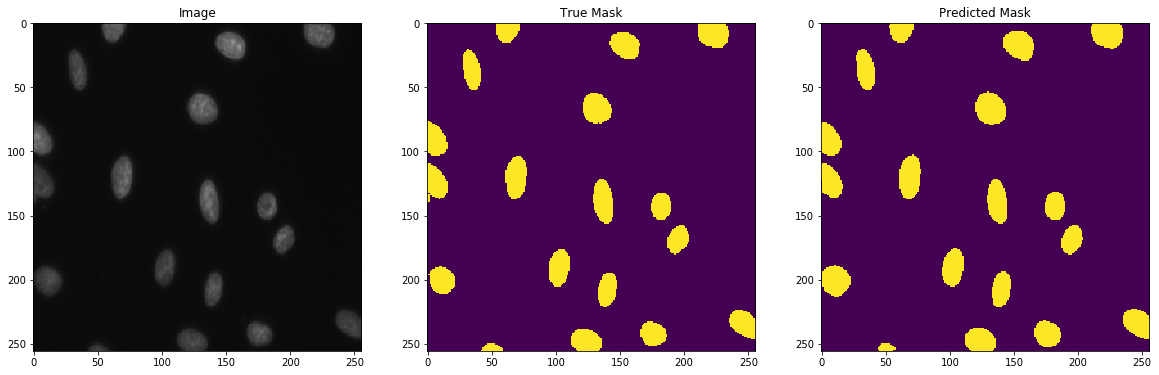

In [16]:
plt.figure(figsize = (20,20))
ix = random.randint(0, len(preds_valid))

plt.subplot(1,3,1)
plt.imshow(X_training[ix])
plt.title('Image')

plt.subplot(1,3,2)
plt.imshow(np.squeeze(Y_training[ix]))
plt.title('True Mask')

plt.subplot(1,3,3)
plt.imshow(np.squeeze(preds_training[ix]>0.5))
plt.title('Predicted Mask')

Text(0.5,1,'Predicted Mask')

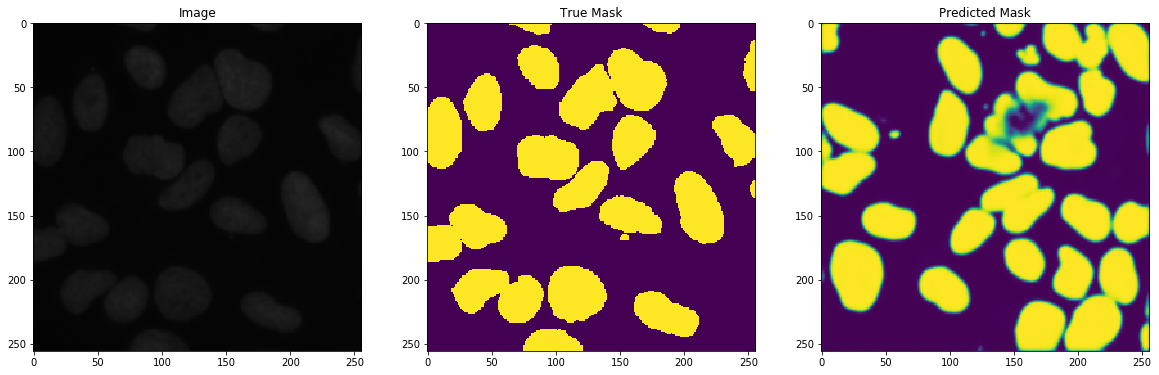

In [18]:
plt.figure(figsize = (20,20))
ix = random.randint(0, len(preds_valid))

plt.subplot(1,3,1)
plt.imshow(X_training[ix])
plt.title('Image')

plt.subplot(1,3,2)
plt.imshow(np.squeeze(Y_training[ix]))
plt.title('True Mask')

plt.subplot(1,3,3)
plt.imshow(np.squeeze(preds_valid[ix]))
plt.title('Predicted Mask')

Text(0.5,1,'Predicted Mask')

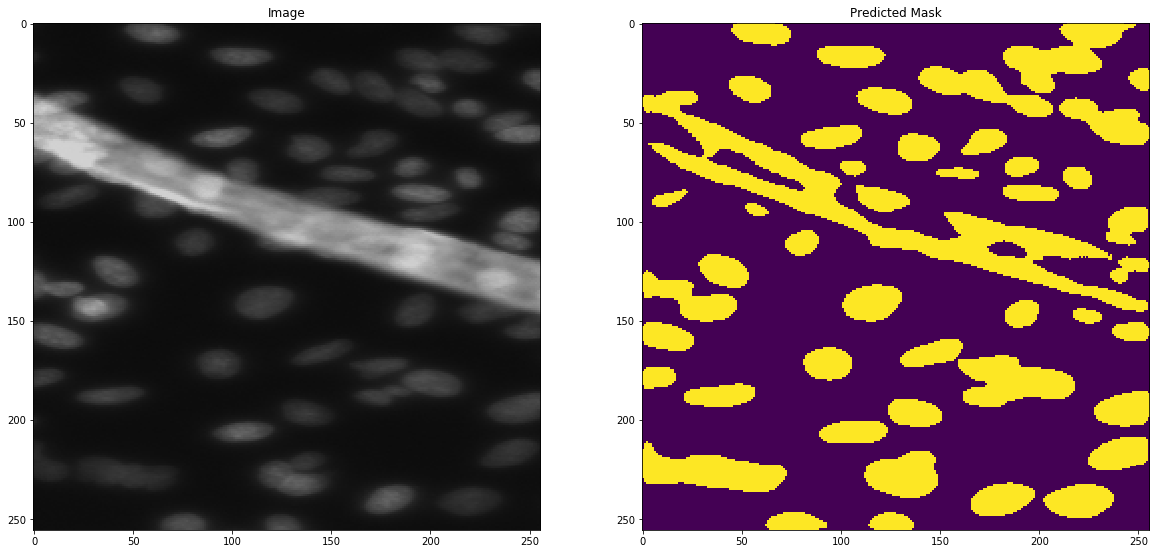

In [34]:
plt.figure(figsize = (20,20))
ix = random.randint(0, len(preds_test))

plt.subplot(1,2,1)
plt.imshow(X_test[ix])
plt.title('Image')
plt.subplot(1,2,2)
plt.imshow(np.squeeze(preds_test[ix]>0.5))
plt.title('Predicted Mask')

In [35]:
pred_test_sub = (preds_test > 0.5).astype(np.uint8)
preds_test_upsampled = []
for i in range(len(pred_test_sub)):
    preds_test_upsampled.append(resize(np.squeeze(pred_test_sub[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True)>0.5)

In [36]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)


In [37]:
new_test_ids = []
rles = []
for n, id_ in enumerate(testing_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [38]:
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('unetwithoutimaug.csv', index=False)

# Unet without Image Augmentation -- comparison 

In [153]:
from keras.layers.normalization import BatchNormalization
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
b1 = BatchNormalization(axis =3)(c1)
p1 = MaxPooling2D((2, 2)) (b1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
b2 = BatchNormalization(axis =3)(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
b3 = BatchNormalization(axis = 3)(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
b4 = BatchNormalization(axis = 3)(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='tanh') (c9)

model_bat = Model(inputs=[inputs], outputs=[outputs])
model_bat.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model_bat.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 256, 256, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, 256, 256, 16) 448         lambda_7[0][0]                   
__________________________________________________________________________________________________
dropout_47 (Dropout)            (None, 256, 256, 16) 0           conv2d_98[0][0]                  
__________________________________________________________________________________________________
conv2d_99 

In [43]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('batchnormal.h5', verbose=1, save_best_only=True)
# history = LossHistory()
results2 = model3.fit(X_training, Y_training,validation_split=0.1, batch_size=16,epochs=50, 
                              callbacks=[ earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/50
603/603 [==============================] - 290s 480ms/step - loss: 0.4321 - mean_iou: 0.0373 - val_loss: 0.2685 - val_mean_iou: 0.0471

Epoch 00001: val_loss improved from inf to 0.26855, saving model to batchnormal.h5
Epoch 2/50
603/603 [==============================] - 289s 480ms/step - loss: 0.2102 - mean_iou: 0.0842 - val_loss: 0.2699 - val_mean_iou: 0.1154

Epoch 00002: val_loss did not improve
Epoch 3/50
603/603 [==============================] - 286s 474ms/step - loss: 0.1585 - mean_iou: 0.1448 - val_loss: 0.1793 - val_mean_iou: 0.1673

Epoch 00003: val_loss improved from 0.26855 to 0.17926, saving model to batchnormal.h5
Epoch 4/50
603/603 [==============================] - 285s 472ms/step - loss: 0.1287 - mean_iou: 0.1861 - val_loss: 0.1415 - val_mean_iou: 0.2027

Epoch 00004: val_loss improved from 0.17926 to 0.14146, saving model to batchnormal.h5
Epoch 5/50
603/603 [==============================] - 285s 473ms/step - 

In [45]:
model4 = load_model('batchnormal.h5', custom_objects={'mean_iou': mean_iou})

preds_training = model4.predict(X_training[:int(X_training.shape[0]*0.9)], verbose=1)
# preds_training = preds_training.reshape(603, 256, 256, 1)

preds_valid = model4.predict(X_training[int(X_training.shape[0]*0.9):], verbose=1)
# preds_valid = preds_valid.reshape(67, 256, 256, 1)

preds_test = model4.predict(X_test, verbose=1)

65/65 [==============================] - 10s 150ms/step


Text(0.5,1,'Predicted Mask')

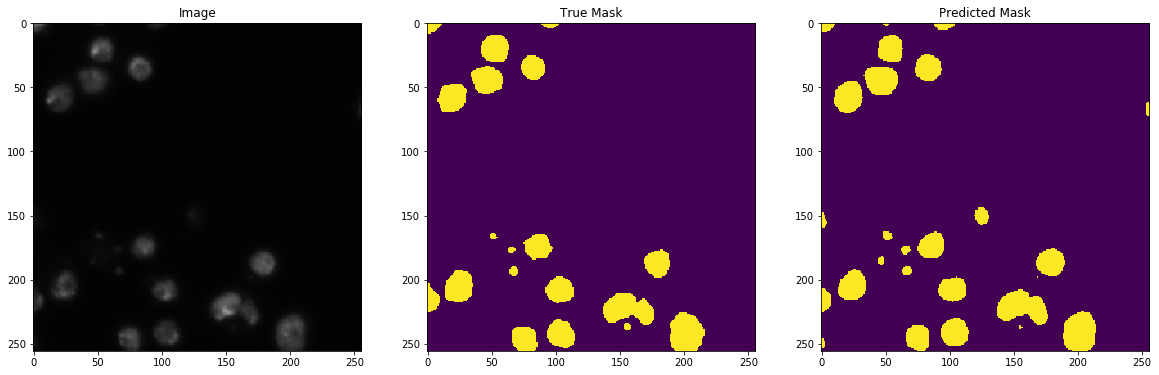

In [110]:
plt.figure(figsize = (20,20))
ix = random.randint(0, len(preds_valid))

plt.subplot(1,3,1)
plt.imshow(X_training[ix+603])
plt.title('Image')

plt.subplot(1,3,2)
plt.imshow(np.squeeze(Y_training[ix+603]))
plt.title('True Mask')

plt.subplot(1,3,3)
plt.imshow(np.squeeze(preds_valid[ix]>0.5))
plt.title('Predicted Mask')

23


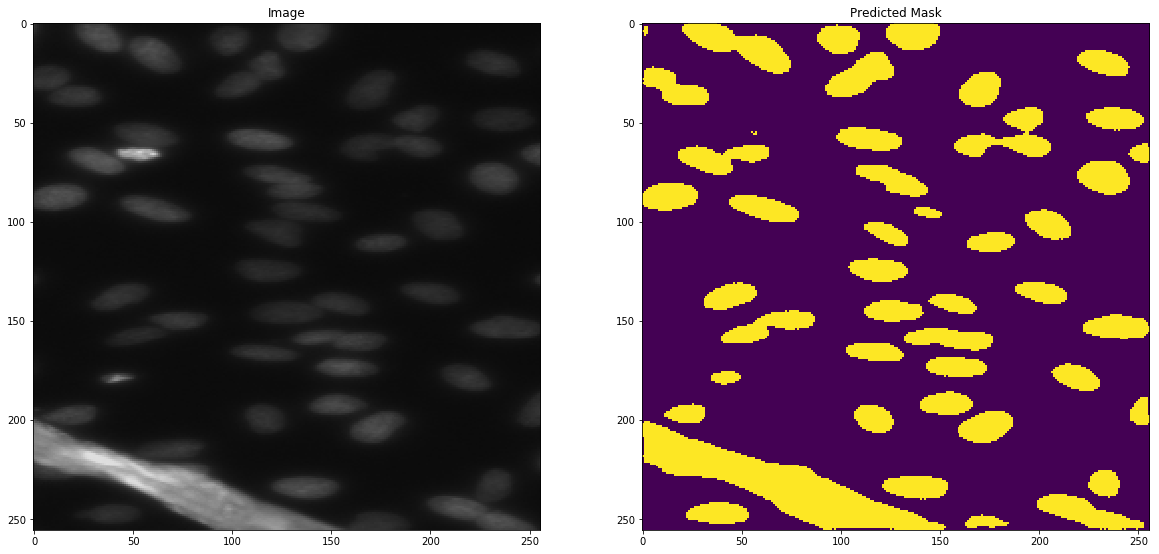

In [98]:
plt.figure(figsize = (20,20))
ix = random.randint(0, len(preds_test))

plt.subplot(1,2,1)
plt.imshow(X_test[ix])
plt.title('Image')
plt.subplot(1,2,2)
plt.imshow(np.squeeze(preds_test[ix]>0.5))
plt.title('Predicted Mask')
print(ix)

In [99]:
pred_test_sub = (preds_test > 0.5).astype(np.uint8)
preds_test_upsampled = []
for i in range(len(pred_test_sub)):
    preds_test_upsampled.append(resize(np.squeeze(pred_test_sub[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [100]:
new_test_ids_NB = []
rles_NB = []
for n, id_ in enumerate(testing_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles_NB.extend(rle)
    new_test_ids_NB.extend([id_] * len(rle))

In [101]:
sub1 = pd.DataFrame()
sub1['ImageId'] = new_test_ids_NB
sub1['EncodedPixels'] = pd.Series(rles_NB).apply(lambda x: ' '.join(str(y) for y in x))
sub1.to_csv('NB.csv', index=False)

In [149]:
pred_test_sub = (preds_test > 0.5).astype(np.uint8)
preds_test_upsampled = []
for i in range(len(pred_test_sub)):
    preds_test_upsampled.append(resize(np.squeeze(pred_test_sub[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))